<center><img src='https://raw.githubusercontent.com/Jangrae/img/master/ml_python.png' width=600/></center>

<img src = "https://github.com/Jangrae/img/blob/master/boston.png?raw=true" width=800 align="left"/>

# 실습 내용

- Random Search로 Decision Tree 알고리즘 모델을 튜닝합니다.


# 1.환경 준비

- 기본 라이브러리와 대상 데이터를 가져와 이후 과정을 준비합니다.

In [27]:
# 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings(action='ignore')
%config InlineBackend.figure_format = 'retina'

In [28]:
# 데이터 읽어오기
path = 'https://raw.githubusercontent.com/jangrae/csv/master/boston.csv'
data = pd.read_csv(path)

# 2.데이터 이해

- 분석할 데이터를 충분히 이해할 수 있도록 다양한 탐색 과정을 수행합니다.

In [29]:
# 상위 몇 개 행 확인
data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


**데이터 설명**

- crim: 자치시(Town)별 1인당 범죄율
- zn: 25,000 평방피트를 초과하는 거주지역 비율
- indus: 비소매상업지역이 점유하고 있는 토지 비율
- chas: 찰스강에 대한 더미 변수 (= 1 강 경계에 위치; 0 나머지)
- nox: 10ppm당 농축 일산화질소
- rm: 주택 1가구당 평균 방 개수
- age: 1940년 이전에 건축된 소유주택 비율
- dis: 5개 보스턴 직업센터까지 접근성 지수
- rad: 방사형 도로까지의 접근성 지수
- tax: 10,000달러 당 재산세율
- ptratio: 자치시(Town)별 학생/교사 비율
- black: 1000(Bk - 0.63)^2, 여기서 Bk는 자치시별 흑인의 비율을 의미
- lstat: 모집단 하위 계층의 비율(%)
- medv: 본인 소유 주택가격(중앙값) (단위:$1,000)

In [30]:
# 기술통계 확인
data.describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


# 3.데이터 준비

- 전처리 과정을 통해 머신러닝 알고리즘에 사용할 수 있는 형태의 데이터를 준비합니다.

**1) x, y 분리**

In [31]:
# target 확인
target = 'medv'

# 데이터 분리
x = data.drop(target, axis=1)
y = data[target]

**2) 학습용, 평가용 데이터 분리**

In [32]:
# 모듈 불러오기
from sklearn.model_selection import train_test_split

# 데이터 분리
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

# 4.성능 예측

- k-Fold Cross Validation을 사용해 모델의 성능을 예측합니다.

In [33]:
# 불러오기
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, RandomizedSearchCV

In [34]:
# 선언하기
model_dt=DecisionTreeRegressor(random_state=1) 

In [35]:
# 성능예측
cv_score = cross_val_score(model_dt, x_train, y_train, cv=10)

In [36]:
# 결과확인
print(cv_score)
print('평균 : ', cv_score.mean())

[0.65714654 0.60626309 0.90288602 0.81947244 0.2399945  0.78389795
 0.78738545 0.76528187 0.84699641 0.807198  ]
평균 :  0.7216522274237595


# 5.모델 튜닝


- Random Search로 튜닝을 진행합니다. 

**1) 모델 튜닝**

- 성능을 확인할 파라미터를 딕셔너리 형태로 선언합니다.
- 기존 모델을 기본으로 RandomizedSearchCV 알고리즘을 사용하는 모델을 선언합니다.
- 다음 정보를 최종 모델에 파라미터로 전달합니다.
    - 기본 모델 이름
    - 파라미터 변수
    - cv: K-Fold 분할 개수(기본값=5)
    - n_iter: 시도 횟수(기본값=10)
    - scoring: 평가 방법

In [37]:
# 파라미터 선언
  # max_depth: 1~50
param = {'max_depth' : range(1, 51)}

# Random Search 선언
  # cv=5
  # n_iter=20
  # scoring='r2'
model = RandomizedSearchCV(model_dt,     # 기본모델
                           param,        # 파라미터 범위
                           cv=5,         # k-Fold CV의 폴더 개수
                           n_iter=20,    # 20개만 랜덤으로 고름, 랜덤으로 시도할 횟수
                           scoring='r2', # 사용할 평가지표
                           )  
    
    

In [38]:
# 학습하기
model.fit(x_train, y_train)

RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=1),
                   n_iter=20, param_distributions={'max_depth': range(1, 51)},
                   scoring='r2')

In [39]:
model.cv_results_

{'mean_fit_time': array([0.00759521, 0.00685263, 0.00638523, 0.00869317, 0.00923023,
        0.0119071 , 0.01015487, 0.00758924, 0.00607505, 0.0080864 ,
        0.0050498 , 0.00563803, 0.0061482 , 0.00576315, 0.00763192,
        0.00872555, 0.00620542, 0.00935488, 0.00532303, 0.00758152]),
 'std_fit_time': array([0.00104074, 0.00164827, 0.00159305, 0.00316993, 0.00267154,
        0.00428901, 0.00273119, 0.0024806 , 0.00180586, 0.00317224,
        0.00090665, 0.0007626 , 0.00103872, 0.00141512, 0.0022313 ,
        0.00470111, 0.00176279, 0.00606069, 0.00057646, 0.00136629]),
 'mean_score_time': array([0.00331264, 0.00328789, 0.00298252, 0.00380044, 0.00352001,
        0.00609641, 0.00391531, 0.00482087, 0.00298033, 0.00303545,
        0.00228066, 0.00276742, 0.00200171, 0.00323067, 0.00303502,
        0.00274978, 0.00239558, 0.00325074, 0.00258155, 0.00269094]),
 'std_score_time': array([8.54007235e-04, 7.57054259e-04, 6.60784318e-04, 2.64445842e-03,
        1.12950626e-03, 3.26303348e-

**2) 결과 확인**

- model.cv_results_ 속성에 성능 테스트와 관련된 많은 정보가 포함되어 있습니다.
- 이 중 중요한 정보를만 추출해서 확인합니다.
- 다음 3가지는 꼭 기억해야 합니다.
    - model.cv_results_['mean_test_score']: 테스트로 얻은 성능
    - model.best_params_: 최적의 파라미터
    - model.best_score_: 최고의 성능

In [40]:
# 중요 정보 확인
print('=' * 80)
print(model.cv_results_['mean_test_score'])
print('-' * 80)
print('최적파라미터:', model.best_params_) 
print('-' * 80)
print('최고성능:', model.best_score_)
print('=' * 80)

[0.71284838 0.71284838 0.70782307 0.71284838 0.71284838 0.71284838
 0.71284838 0.74748839 0.70563236 0.71284838 0.70622958 0.71284838
 0.71284838 0.71284838 0.71250015 0.71284838 0.71284838 0.71284838
 0.70928798 0.71284838]
--------------------------------------------------------------------------------
최적파라미터: {'max_depth': 6}
--------------------------------------------------------------------------------
최고성능: 0.7474883885080482


**3) 변수 중요도**

- model.best_estimator_ 모델의 변수 중요도를 확인합니다.

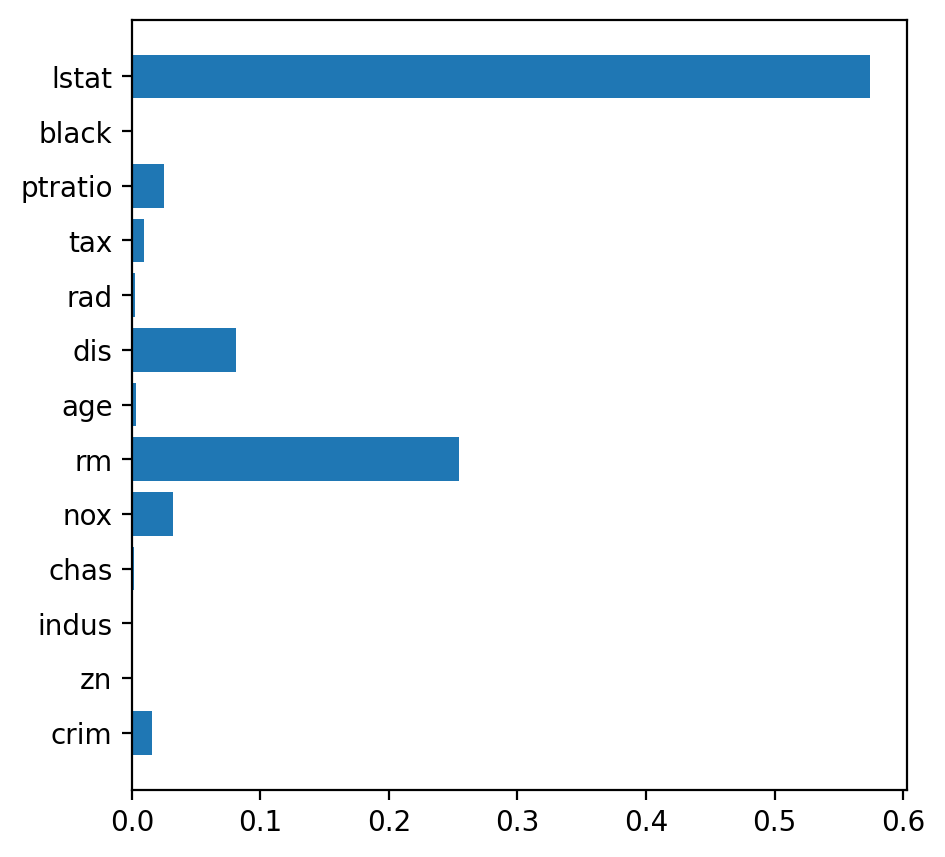

In [41]:
# 변수 중요도
plt.figure(figsize=(5, 5))
plt.barh(y=list(x), width=model.best_estimator_.feature_importances_) #시각화 할때 best_estimator_ 필수!!
plt.show()

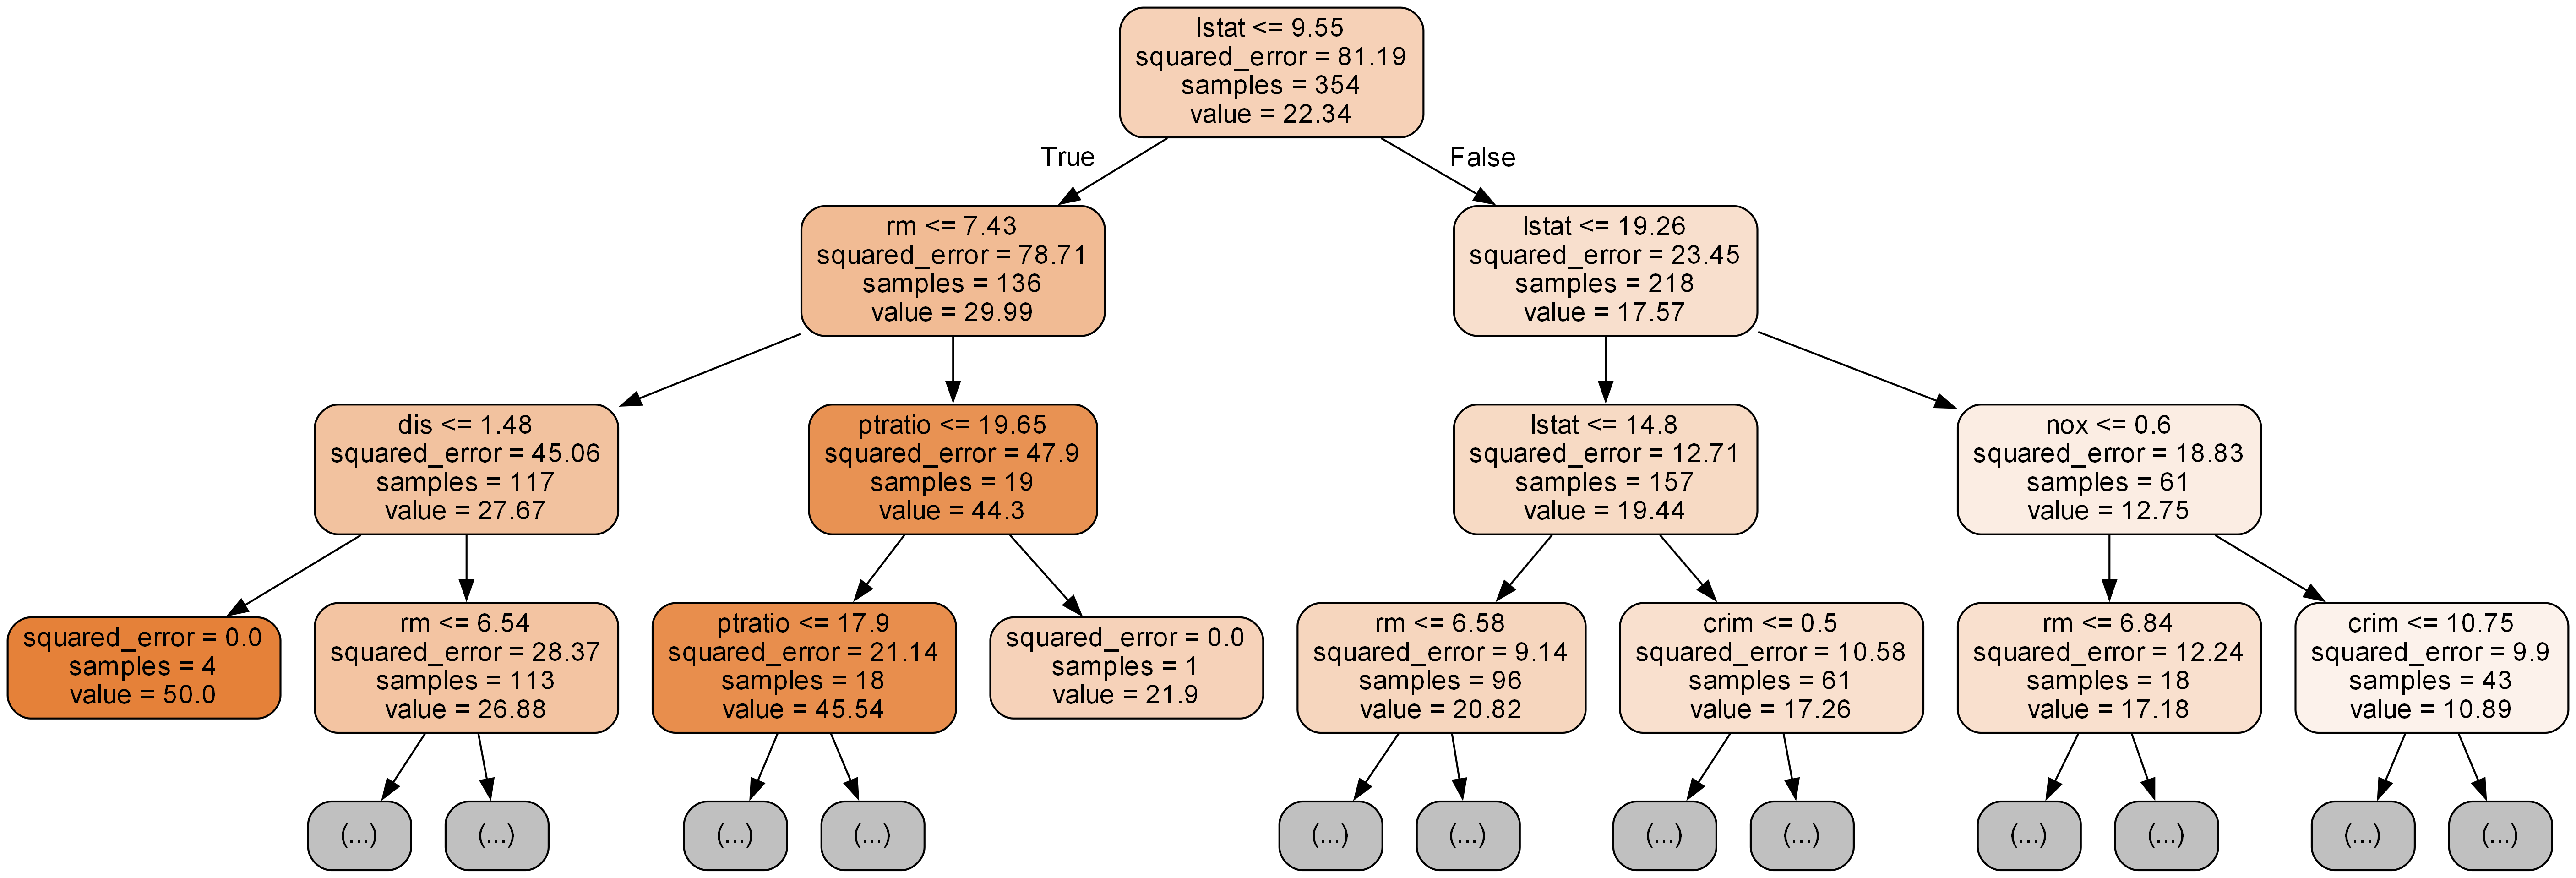

In [42]:
# 시각화 모듈 불러오기
from sklearn.tree import export_graphviz
from IPython.display import Image

# 이미지 파일 만들기
export_graphviz(model.best_estimator_,                                 # 모델 이름
                out_file='tree.dot',                   # 파일 이름 
                feature_names=x.columns,               # Feature 이름
                rounded=True,                          # 둥근 테두리
                precision=2,                           # 불순도 소숫점 자리수
                max_depth=3,                           # 출력할 트리 깊이 지정, 위에서는 모델을 만들때 지정하지만 여기선 그 부분까지 잘라 보여주는 형식
                filled=True)                           # 박스 내부 채우기

# 파일 변환
!dot tree.dot -Tpng -otree.png -Gdpi=300

# 이미지 파일 표시
Image(filename='tree.png')

# 6. 성능 평가

- 학습을 통해 예상한 성능과 실제 평가에 따른 성능은 차이가 있을 수 있습니다.
- 예선전에서 성적이 좋았다고 본선에서도 성적이 좋다고 보장할 수는 없겠지요?

In [43]:
# 예측하기
y_pred = model.predict(x_test)

In [44]:
# 평가하기
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R2-Score:', r2_score(y_test, y_pred))

MAE: 2.763239793643037
R2-Score: 0.8477248406093285
